# Scikit-activeml with Skorch LB

In this brief tutorial, we show an example use-case of our package `skactiveml` with the Python package [skorch](https://skorch.readthedocs.io/en/stable/), which is a scikit-learn wrapper for Pytorch models. This way, we are able to implement and test deep learning models in combination with query strategies implemented in our framework.

In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from sklearn.metrics import accuracy_score
from torch import nn
import torch.nn.functional as F

from skactiveml.utils import majority_vote

mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

## Loading Music Data Set

In [2]:
data_dir = "./music-multi-annotator-dataset"

In [3]:
X_train = np.load(f'{data_dir}/music-X.npy')
y_train = np.load(f'{data_dir}/music-y.npy')
y_train_true = np.load(f'{data_dir}/music-y-true.npy')
X_valid = np.load(f'{data_dir}/music-X-valid.npy')
y_valid = np.load(f'{data_dir}/music-y-true-valid.npy')
X_test = np.load(f'{data_dir}/music-X-test.npy')
y_test_true = np.load(f'{data_dir}/music-y-true-test.npy')

dataset_classes = np.unique(y_test_true)
n_classes = len(dataset_classes)
n_features = X_train.shape[1]
print(X_train.shape)

(700, 124)


## Neural Network Ensemble for tabular data set
In the next step, we define a neural network ensemble for tabular data set

In [4]:
# Define base module.
class ClassifierModule(nn.Module):
    def __init__(self, n_classes, dropout, transform=None):
        super(ClassifierModule, self).__init__()
        n_hidden_neurons = 128
        self.embed_X_block = nn.Sequential(
            nn.Linear(in_features=124, out_features=n_hidden_neurons),
            nn.BatchNorm1d(num_features=n_hidden_neurons),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )
        self.mlp = nn.Linear(in_features=n_hidden_neurons, out_features=n_classes)

    def forward(self, x):
        
        embed_x = self.embed_X_block(x)
        logit_class = self.mlp(embed_x)       

        # Compute class-membership probabilities.
        p_class = F.softmax(logit_class, dim=-1)

        return p_class

In [5]:
from skactiveml.base import SkactivemlClassifier
from skorch import NeuralNet
from skactiveml.utils import is_labeled
from skorch.dataset import Dataset
from skorch.helper import predefined_split

In [6]:
class SkorchClassifier(NeuralNet, SkactivemlClassifier):
    def __init__(
        self,
        module,
        *args,
        classes=None,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=None,
        **module_kwargs,
    ):
        n_classes = len(classes)
        super(SkorchClassifier, self).__init__(
            module,
            *args,
            module__n_classes=n_classes,
            **module_kwargs,
        )
        
        SkactivemlClassifier.__init__(
            self,
            classes=classes,
            missing_label=missing_label,
            cost_matrix=cost_matrix,
            random_state=random_state,
        )

    def get_loss(self, y_pred, y_true, *args, **kwargs):
        loss = super(SkorchClassifier, self).get_loss(y_pred, y_true, *args, **kwargs)
        return loss

    def fit(self, X, y, **fit_params):
        # check input parameters
        self.check_X_dict_ = {
            "ensure_min_samples": 0,
            "ensure_min_features": 0,
            "allow_nd": True,
            "dtype": None,
        }
        X, y, sample_weight = self._validate_data(
            X=X,
            y=y,
            check_X_dict=self.check_X_dict_,
        )

        # check whether model is a valid model

        is_lbld = is_labeled(y, missing_label=self.missing_label)
        try:
            X_lbld = X[is_lbld]
            y_lbld = y[is_lbld].astype(np.int64)
            return super(SkorchClassifier, self).fit(X_lbld, y_lbld, **fit_params)
        except Exception as e:
            self.is_fitted_ = False
            return self

    def initialize(self):
        super(SkorchClassifier, self).check_training_readiness()
        
        super(SkorchClassifier, self)._initialize_virtual_params()
        super(SkorchClassifier, self)._initialize_callbacks()
        super(SkorchClassifier, self)._initialize_module()
        super(SkorchClassifier, self)._initialize_criterion()
        super(SkorchClassifier, self)._initialize_optimizer()
        super(SkorchClassifier, self)._initialize_history()
        
        self.initialized_ = True
        return self

    def predict(self, X):
        return SkactivemlClassifier.predict(self, X)
        

In [7]:
valid_ds = Dataset(X_valid, y_valid)

In [8]:
net = SkorchClassifier(
        ClassifierModule,
        classes=dataset_classes,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=1,
        criterion=nn.CrossEntropyLoss(),
        train_split=predefined_split(valid_ds),
        max_epochs=100,
        batch_size=16,
        optimizer_lr=0.01,
        verbose=False,
        optimizer=torch.optim.AdamW,
        device=device,
        module__dropout=0.0,
        optimizer__weight_decay=0.01
    )

In [9]:
net.initialize()

<class '__main__.SkorchClassifier'>[initialized](
  module_=ClassifierModule(
    (embed_X_block): Sequential(
      (0): Linear(in_features=124, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
    )
    (mlp): Linear(in_features=128, out_features=10, bias=True)
  ),
)

## Active Classification
For our ensemble, we evaluate four different query strategies, i.e., random sampling, uncertainty sampling, query-by-committee, and batch BALD, regarding their sample selection. For this purpose, we start with ten labels and make 30 iterations of an active learning cycle with a batch size of 32.

In [10]:
l = int(0.6*len(y_train_true))

In [11]:
y_train_mv = majority_vote(y_train, classes=dataset_classes, missing_label=-1)

In [12]:
accuracy_score(y_train_true, y_train_mv)

0.6971428571428572

In [13]:
# Define setup.
torch.manual_seed(RANDOM_STATE)

# Create array of missing labels as initial labels.
y = np.full_like(y_train_true, fill_value=MISSING_LABEL, dtype=np.int64)
y = y_train_mv
X = X_train
net.fit(X,y)

y_pred = net.predict(X_test)
print(y_pred[:20])
print(y_test_true[:20])

print(accuracy_score(y_pred, y_test_true))
# should be 0.646 from MaDL / 0.66

[1 9 2 9 1 2 4 1 1 7 9 2 4 2 7 9 7 0 9 7]
[1 8 2 6 1 7 8 1 1 7 3 2 4 2 3 4 7 5 7 8]
0.544


In [14]:
y_train_pred = net.predict(X_train)
print(y_train_pred[:20])
print(y_train_true[:20])
accuracy_score(y_train_true, y_train_pred)
# 0.646 from MaDL (test_accuracy) / train_accuracy: 76%

[4 2 4 9 8 7 2 2 8 9 0 9 7 2 2 0 5 2 8 9]
[4 7 4 7 8 3 2 2 8 3 0 6 7 2 2 0 5 2 8 9]


0.6085714285714285

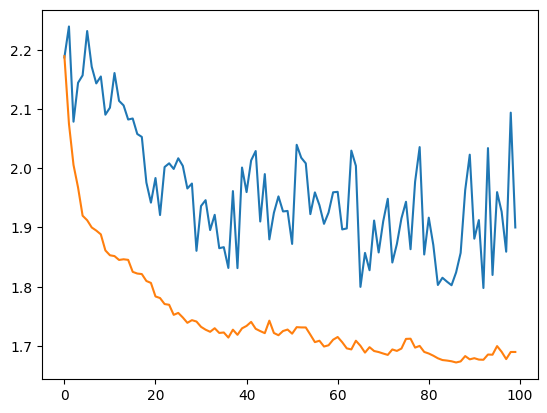

In [15]:
history = net.history
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']
plt.plot(valid_loss)
plt.plot(train_loss)